In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import confusion_matrix
%matplotlib inline
from datetime import timedelta
import math
import tensorflow as tf
import time

In [2]:
tf.__version__

'1.4.0'

## Setting Hyperparameters

In [3]:
filter_size1= 5
num_filters1= 16

filter_size2= 5
num_filters2=36

fc_size=128

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data=input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
print("Size of")
print("--train labels     : ",len(data.train.labels))
print("--validation labels: ",len(data.validation.labels))
print("--test labels      : ",len(data.test.labels))

Size of
--train labels     :  55000
--validation labels:  5000
--test labels      :  10000


In [6]:
data.test.cls=np.argmax(data.test.labels, axis=1)

## Data dimensions

In [7]:
img_size=28
img_size_flat=img_size*img_size
img_shape=(img_size,img_size)
num_channels=1
num_classes=10

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images)== len(cls_true)==9
    
    fig, axes=plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape),cmap='binary')
        
        if cls_pred is None:
            xlabel="True: {}".format(cls_true[i])
        else:
            xlabel= "True: {} Predict: {}".format(cls_true[i],cls_pred[i])
        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()
    

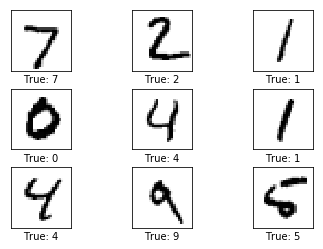

In [9]:
images=data.test.images[0:9]

cls_true=data.test.cls[0:9]

plot_images(images=images,cls_true=cls_true)

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

In [11]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))

In [12]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
    shape=[filter_size,filter_size,num_input_channels, num_filters]
    
    weights=new_weights(shape)
    
    bias=new_biases(length=num_filters)
    
    layer=tf.nn.conv2d(input=input, filter=weights,strides=[1,1,1,1], padding="SAME")
    
    layer=tf.nn.bias_add(layer,bias)
    
    if use_pooling:
        layer=tf.nn.max_pool(value=layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
        
    layer=tf.nn.relu(layer)
    
    
    return layer,weights 

In [13]:
def flatten_layer(layer):
    layer_shape=layer.get_shape()
    
    num_features=layer_shape[1:4].num_elements()
    
    layer_flat=tf.reshape(layer,[-1,num_features])
    
    return layer_flat,num_features

In [14]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    
    weights=new_weights(shape=[num_inputs,num_outputs])
    
    bias=new_biases(num_outputs)
    
    layer=tf.add(tf.matmul(input, weights),bias)
    
    if use_relu:
        layer=tf.nn.relu(layer)
    
    return layer

## Placeholder 

In [15]:
x=tf.placeholder(tf.float32, shape=[None, img_size_flat],name= 'x')
x_image=tf.reshape(x,[-1,img_size,img_size,num_channels])

In [16]:
y_true=tf.placeholder(tf.float32, shape=[None,10], name='y_true')
y_true_cls=tf.argmax(y_true,dimension=1)

Instructions for updating:
Use the `axis` argument instead


## Conv 1

In [17]:
layer_conv1,weights_conv1=new_conv_layer(input=x_image, num_input_channels=num_channels,
                                        filter_size=filter_size1, num_filters=num_filters1,
                                         use_pooling=True)

In [18]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

## Conv 2

In [19]:
layer_conv2,weights_conv2=new_conv_layer(input=layer_conv1,num_input_channels=num_filters1,
                                        filter_size=filter_size2, num_filters=num_filters2,
                                        use_pooling=True)

In [20]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

## Flatten

In [21]:
layer_flat,num_features=flatten_layer(layer_conv2)

In [22]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [23]:
num_features

1764

## Fully conn 1

In [24]:
layer_fc1=new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size,
                       use_relu=True)

In [25]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

## Fully conn 2

In [26]:
layer_fc2=new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=num_classes,
                      use_relu=False)

In [27]:
layer_fc2

<tf.Tensor 'Add_1:0' shape=(?, 10) dtype=float32>

## Predicted Class

In [28]:
y_pred=tf.nn.softmax(layer_fc2)

y_pred_cls=tf.argmax(y_pred,axis=1)

## Optimization Method

In [29]:
cross_entropy=tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)

In [30]:
cost=tf.reduce_mean(cross_entropy)

In [33]:
optimizer=tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [34]:
correct_prediction=tf.equal(y_pred_cls,y_true_cls)

In [35]:
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

# Tensorflow run

In [36]:
sess=tf.Session()

In [37]:
sess.run(tf.global_variables_initializer())

In [38]:
train_batch_size=64

In [39]:
total_iterations=0

def optimize(num_iterations):
    global total_iterations
    
    start_time=time.time()
    for i in range(total_iterations,total_iterations+num_iterations):
        x_batch,y_true_batch=data.train.next_batch(train_batch_size)
        
        feed_dict_train={x:x_batch,y_true :y_true_batch}
        
        sess.run(optimizer,feed_dict=feed_dict_train)
        
        if i%100==0:
            acc=sess.run(accuracy, feed_dict=feed_dict_train)
            
            print("Optimization Iteration:{0:>5}  , Accuracy: {1:>6.1%}".format((i+1),acc))
        
    end_time=time.time()
        
    total_time=end_time-start_time
        
    print("Time Used: "+str(timedelta(seconds=int(round(total_time)))))

In [40]:
def plot_example_errors(cls_pred, correct):
    incorrect=(correct==False)
    
    images=data.test.images[incorrect]
    
    cls_pred=cls_pred[incorrect]
    
    cls_true=data.test.cls[incorrect]
    
    plot_images(images=images[0:9],cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])
    
    

In [41]:
def plot_confusion_matrix(cls_pred):
    
    cls_true=data.test.cls
    
    cm=confusion_matrix(y_true=cls_true,y_pred=cls_pred)
    
    print(cm)
    
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks=np.arange(num_classes)
    plt.xticks(tick_marks,range(num_classes))
    plt.yticks(tick_marks,range(num_classes))
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()
    

In [42]:
test_batch_size = 128

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(data.test.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)

        images = data.test.images[i:j, :]

        labels = data.test.labels[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    cls_true = data.test.cls

    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [43]:
print_test_accuracy()

Accuracy on Test-Set: 7.4% (742 / 10000)


In [44]:
optimize(num_iterations=1)
print_test_accuracy()

Optimization Iteration:    1  , Accuracy:  12.5%
Time Used: 0:00:01
Accuracy on Test-Set: 8.9% (892 / 10000)


In [45]:
optimize(num_iterations=99)


Optimization Iteration:    1  , Accuracy:  14.1%
Time Used: 0:00:03


Accuracy on Test-Set: 66.6% (6656 / 10000)
Example errors:


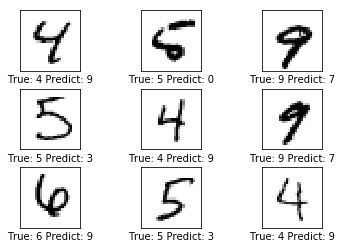

In [46]:
print_test_accuracy(show_example_errors=True)

In [47]:
optimize(num_iterations=900)

Optimization Iteration:    1  , Accuracy:  59.4%
Optimization Iteration:  101  , Accuracy:  81.2%
Optimization Iteration:  201  , Accuracy:  87.5%
Optimization Iteration:  301  , Accuracy:  93.8%
Optimization Iteration:  401  , Accuracy:  92.2%
Optimization Iteration:  501  , Accuracy:  89.1%
Optimization Iteration:  601  , Accuracy:  93.8%
Optimization Iteration:  701  , Accuracy:  95.3%
Optimization Iteration:  801  , Accuracy:  93.8%
Time Used: 0:00:19


Accuracy on Test-Set: 93.7% (9372 / 10000)
Example errors:


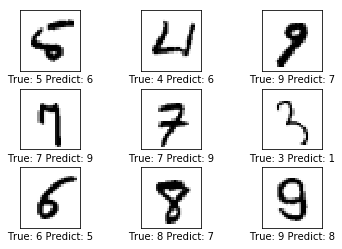

In [48]:
print_test_accuracy(show_example_errors=True)

In [49]:
optimize(num_iterations=9000)

Optimization Iteration:    1  , Accuracy:  93.8%
Optimization Iteration:  101  , Accuracy:  92.2%
Optimization Iteration:  201  , Accuracy:  95.3%
Optimization Iteration:  301  , Accuracy:  92.2%
Optimization Iteration:  401  , Accuracy:  92.2%
Optimization Iteration:  501  , Accuracy:  98.4%
Optimization Iteration:  601  , Accuracy:  93.8%
Optimization Iteration:  701  , Accuracy:  95.3%
Optimization Iteration:  801  , Accuracy:  96.9%
Optimization Iteration:  901  , Accuracy:  98.4%
Optimization Iteration: 1001  , Accuracy:  96.9%
Optimization Iteration: 1101  , Accuracy:  89.1%
Optimization Iteration: 1201  , Accuracy:  93.8%
Optimization Iteration: 1301  , Accuracy:  90.6%
Optimization Iteration: 1401  , Accuracy:  89.1%
Optimization Iteration: 1501  , Accuracy:  98.4%
Optimization Iteration: 1601  , Accuracy:  95.3%
Optimization Iteration: 1701  , Accuracy:  98.4%
Optimization Iteration: 1801  , Accuracy:  98.4%
Optimization Iteration: 1901  , Accuracy:  96.9%
Optimization Iterati

Accuracy on Test-Set: 98.5% (9853 / 10000)
Example errors:


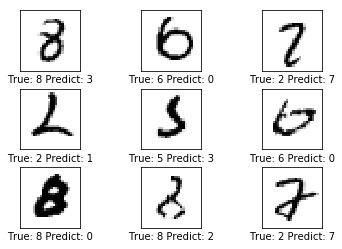

Confusion Matrix:
[[ 975    1    0    0    0    0    1    1    2    0]
 [   0 1131    2    0    0    0    0    2    0    0]
 [   6    4 1004    3    1    0    0   11    3    0]
 [   1    0    0 1003    0    2    0    2    2    0]
 [   0    1    0    0  969    0    0    2    0   10]
 [   2    0    0    6    0  879    1    0    1    3]
 [   9    3    0    0    5    7  934    0    0    0]
 [   0    1    1    2    0    0    0 1023    0    1]
 [   7    2    2    3    1    4    0    7  945    3]
 [   2    5    0    1    3    3    0    4    1  990]]


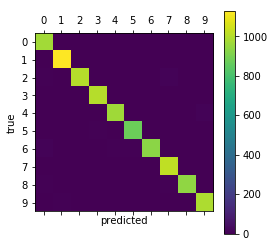

In [50]:
print_test_accuracy(show_example_errors=True,
                   show_confusion_matrix=True)

In [70]:
def plot_conv_weights(weights,input_channel=0):
    w=sess.run(weights)
    
    min=np.min(w)
    max=np.max(w)
    
    num_filters=w.shape[3]
    
    num_grids=math.ceil(math.sqrt(num_filters))
    
    fig, axes= plt.subplots(num_grids,num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img=w[:,:,input_channel, i]
            
            ax.imshow(img,vmin=min, vmax=max, interpolation='nearest', cmap='seismic')
            
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()        

In [74]:
def plot_conv_layer(layer,image):
    feed_dict={x:[image]}
    
    values=sess.run(layer,feed_dict=feed_dict)
    
    num_filters=values.shape[3]
    
    num_grids=math.ceil(math.sqrt(num_filters))
    
    fig,axes=plt.subplots(num_grids,num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            
            img=values[0,:,:,i]
            
            ax.imshow(img, interpolation='nearest', cmap='binary')
            
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [57]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape), interpolation='nearest', cmap='binary')
    
    plt.show()

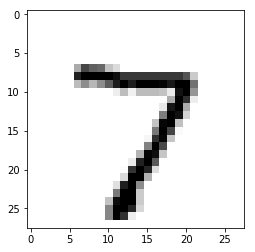

In [58]:
image1=data.test.images[0]
plot_image(image1)

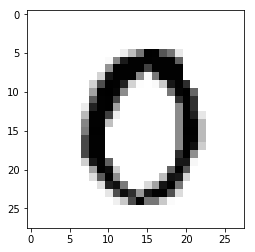

In [59]:
image2=data.test.images[13]
plot_image(image2)

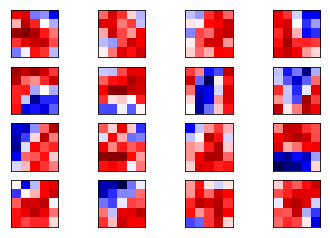

In [71]:
plot_conv_weights(weights=weights_conv1)

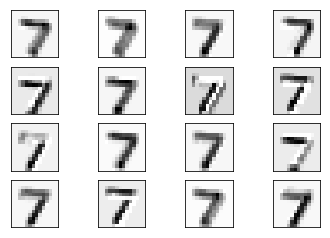

In [75]:
plot_conv_layer(layer=layer_conv1,image=image1)

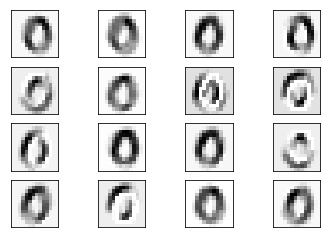

In [76]:
plot_conv_layer(layer=layer_conv1,image=image2)

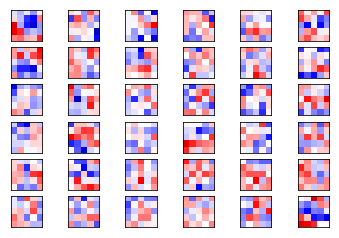

In [78]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

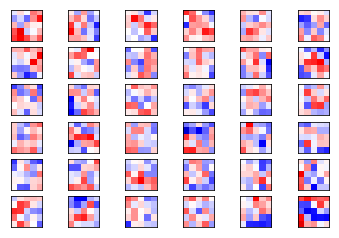

In [79]:
plot_conv_weights(weights=weights_conv2,input_channel=1)

In [80]:
sess.close()